# Supervised learning with the KDDCUP99 Dataset

### Instrall dependencies

In [31]:
%pip install scikit-learn
%pip install pandas
%pip install numpy
%pip install matplotlib
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
   ---------------------------------------- 0.0/294.9 kB ? eta -:--:--
   ---------------------------------------- 0.0/294.9 kB ? eta -:--:--
   ---------------------------------------- 0.0/294.9 kB ? eta -:--:--
   - -------------------------------------- 10.2/294.9 kB ? eta -:--:--
   - -------------------------------------- 10.2/294.9 kB ? eta -:--:--
   -------- ------------------------------ 61.4/294.9 kB 409.6 kB/s eta 0:00:01
   -------------- ----------------------- 112.6/294.9 kB 652.2 kB/s eta 0:00:01
   ---------------------- --------------- 174.1/294.9 kB 803.1 kB/s eta 0:00:01
   ------------------------------- ------ 245.8/294.9 kB 942.1 kB/s eta 0:00:01
   -------------------------------------- 294.9/294.9 kB 95

### Importing libraries needed

In [32]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import IsolationForest
from sklearn import svm
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import SGDOneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.pipeline import make_pipeline


from sklearn.decomposition import PCA


### Load the Data

10065 datapoints with 338 anomalies (3.36%)


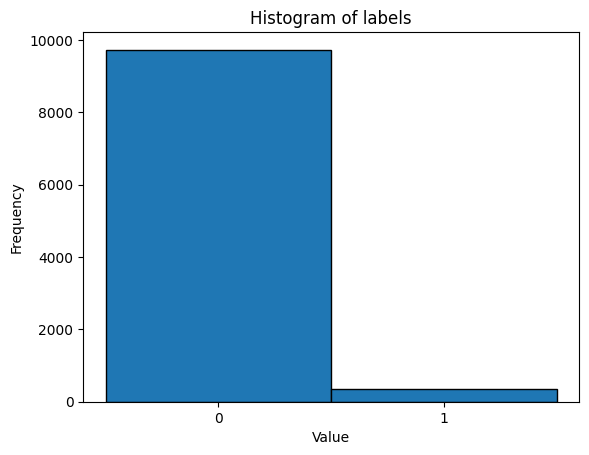

In [33]:
# Load KDD Cup 99 dataset
X, y = datasets.fetch_kddcup99(
    subset="SA", percent10=True, random_state=42, return_X_y=True, as_frame=True
)
y = (y != b"normal.").astype(np.int32)
X, _, y, _ = train_test_split(X, y, train_size=0.1, stratify=y, random_state=42)

n_samples, anomaly_frac = X.shape[0], y.mean()
print(f"{n_samples} datapoints with {y.sum()} anomalies ({anomaly_frac:.02%})")
# Create histogram
plt.hist(y, bins=[-0.5, 0.5, 1.5], edgecolor='black')
plt.xticks([0, 1])
plt.title('Histogram of labels')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

### Make a Prediction

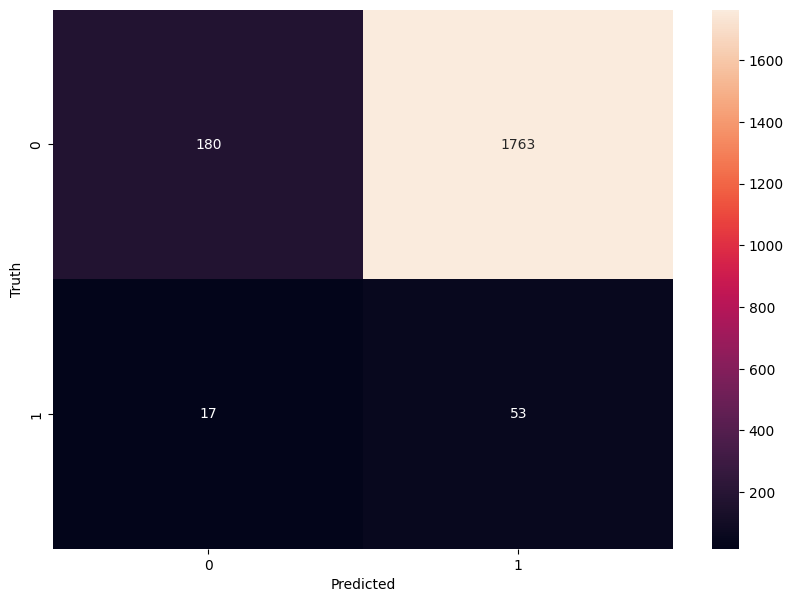

In [34]:
# Convert categorical variables to numerical format
X = pd.get_dummies(X)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Use Isolation Forest for novelty and outlier detection
clf = IsolationForest(contamination=0.1)
clf.fit(X_train)

# Predict the outliers in the test set
y_pred = clf.predict(X_test)

# Convert y_pred to binary format
y_pred_binary = [1 if pred == 1 else 0 for pred in y_pred]

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Create a heatmap
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

plt.show()

### Detect Outliers

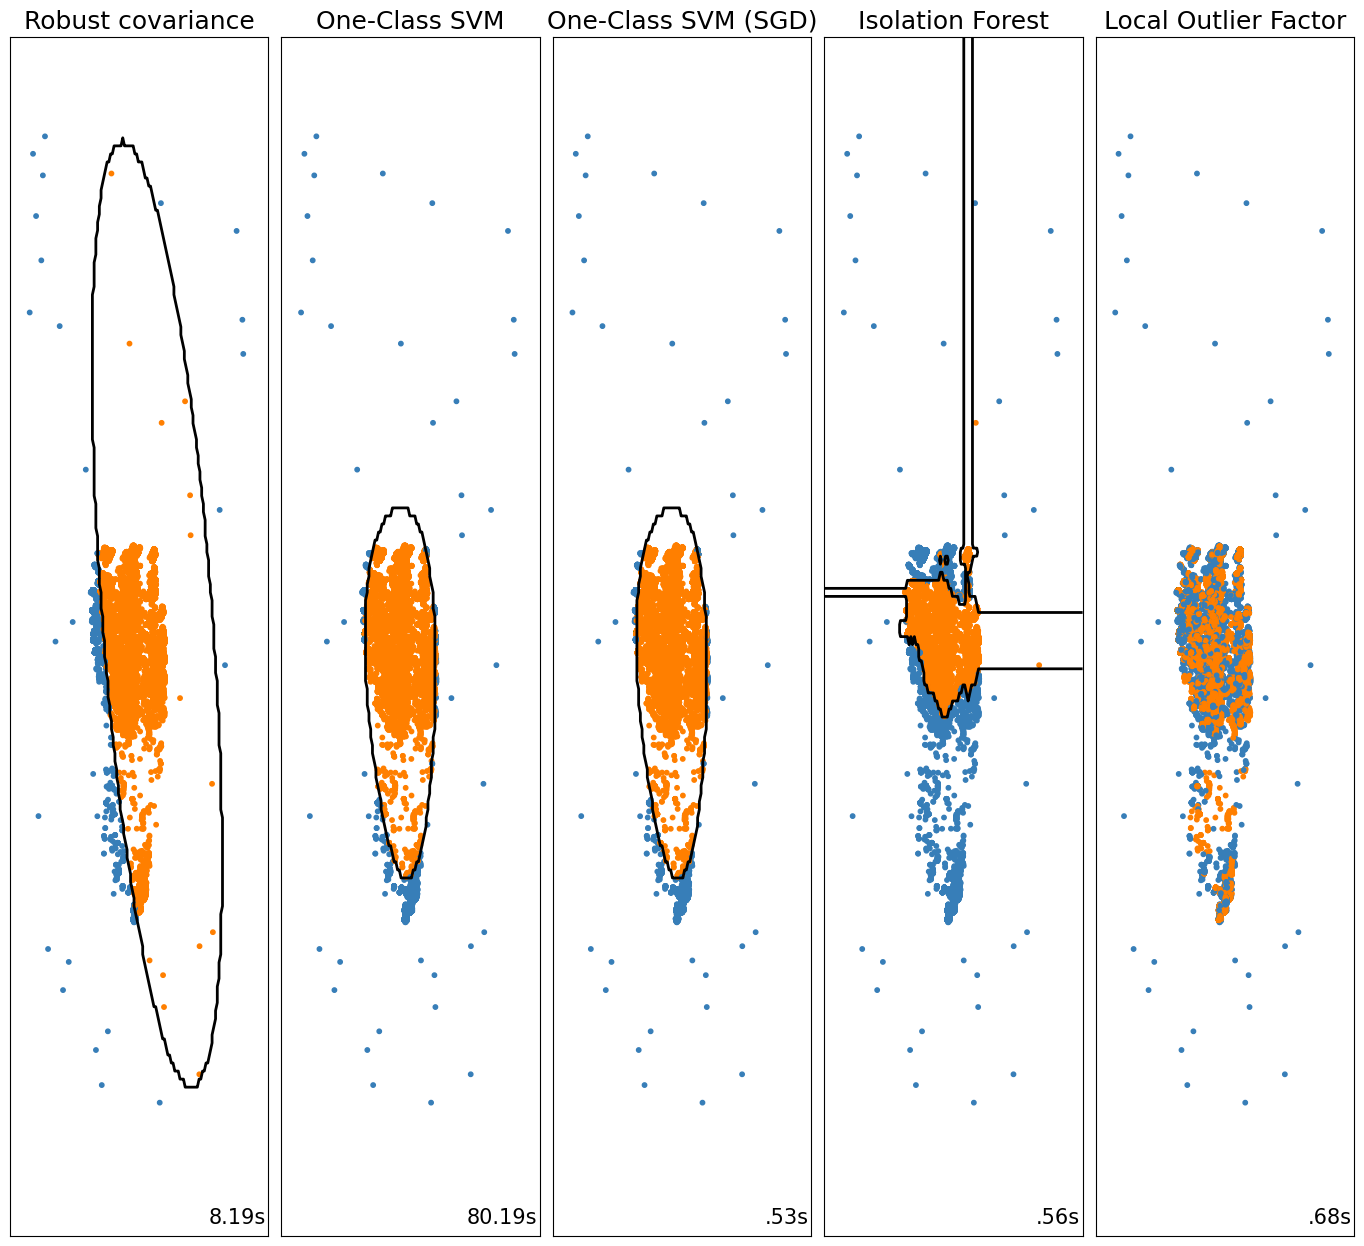

In [37]:
# Example from: https://scikit-learn.org/stable/auto_examples/miscellaneous/plot_anomaly_comparison.html#sphx-glr-auto-examples-miscellaneous-plot-anomaly-comparison-py

matplotlib.rcParams["contour.negative_linestyle"] = "solid"

# Load KDDCup99 dataset
kddcup99 = datasets.fetch_kddcup99(subset='SA', percent10=True)

# Preprocess the data
X = kddcup99.data
y = kddcup99.target

# Convert categorical features to numerical using one-hot encoding
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')
X = enc.fit_transform(X)

# Reduce dimensionality to 2D using PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.toarray())


# Example settings
n_samples = 300
outliers_fraction = 0.15
n_outliers = int(outliers_fraction * n_samples)
n_inliers = n_samples - n_outliers

# define outlier/anomaly detection methods to be compared.
# the SGDOneClassSVM must be used in a pipeline with a kernel approximation
# to give similar results to the OneClassSVM
anomaly_algorithms = [
    (
        "Robust covariance",
        EllipticEnvelope(contamination=outliers_fraction, random_state=42),
    ),
    ("One-Class SVM", svm.OneClassSVM(nu=outliers_fraction, kernel="rbf", gamma=0.1)),
    (
        "One-Class SVM (SGD)",
        make_pipeline(
            Nystroem(gamma=0.1, random_state=42, n_components=150),
            SGDOneClassSVM(
                nu=outliers_fraction,
                shuffle=True,
                fit_intercept=True,
                random_state=42,
                tol=1e-6,
            ),
        ),
    ),
    (
        "Isolation Forest",
        IsolationForest(contamination=outliers_fraction, random_state=42),
    ),
    (
        "Local Outlier Factor",
        LocalOutlierFactor(n_neighbors=35, contamination=outliers_fraction),
    ),
]

# Define datasets
datasets = [X_pca]

# Compare given classifiers under given settings
xx, yy = np.meshgrid(np.linspace(-7, 7, 150), np.linspace(-7, 7, 150))

plt.figure(figsize=(len(anomaly_algorithms) * 2 + 4, 12.5))
plt.subplots_adjust(
    left=0.02, right=0.98, bottom=0.001, top=0.96, wspace=0.05, hspace=0.01
)

plot_num = 1
rng = np.random.RandomState(42)

for i_dataset, X in enumerate(datasets):
    # Add outliers
    X = np.concatenate([X, rng.uniform(low=-6, high=6, size=(n_outliers, 2))], axis=0)

    for name, algorithm in anomaly_algorithms:
        t0 = time.time()
        algorithm.fit(X)
        t1 = time.time()
        plt.subplot(len(datasets), len(anomaly_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        # fit the data and tag outliers
        if name == "Local Outlier Factor":
            y_pred = algorithm.fit_predict(X)
        else:
            y_pred = algorithm.fit(X).predict(X)

        # plot the levels lines and the points
        if name != "Local Outlier Factor":  # LOF does not implement predict
            Z = algorithm.predict(np.c_[xx.ravel(), yy.ravel()])
            Z = Z.reshape(xx.shape)
            plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors="black")

        colors = np.array(["#377eb8", "#ff7f00"])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[(y_pred + 1) // 2])

        plt.xlim(-7, 7)
        plt.ylim(-7, 7)
        plt.xticks(())
        plt.yticks(())
        plt.text(
            0.99,
            0.01,
            ("%.2fs" % (t1 - t0)).lstrip("0"),
            transform=plt.gca().transAxes,
            size=15,
            horizontalalignment="right",
        )
        plot_num += 1

plt.show()